<a href="https://colab.research.google.com/github/ming-90/Kaggle_Study/blob/main/3.segmentation/nuclei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [37]:
cd /content/drive/MyDrive/Colab\ Notebooks/nuclei

/content/drive/MyDrive/Colab Notebooks/nuclei


In [38]:
ls

nuclei.ipynb  stage1_test/  stage1_train/  stage1_train_labels.csv/


In [ ]:
import pathlib
import imageio
import numpy as np
import glob
traing_path = pathlib.Path('./stage1_train').glob('*/images/*.png')
training_sored = sorted([x for x in traing_path])
im_path = training_sored[45]
# 이미지 파일 읽기
im = imageio.imread(str(im_path))

In [45]:
# origin image shape
print(im.shape)

from skimage.color import rgb2gray
im_gray = rgb2gray(im)

print(im_gray.shape)

(520, 696, 4)
(520, 696)


In [51]:
from skimage.filters import threshold_otsu

#이진화 작업인듯
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

if np.sum(mask == 0) < np.sum(mask == 1):
    mask = np.where(mask, 0, 1)

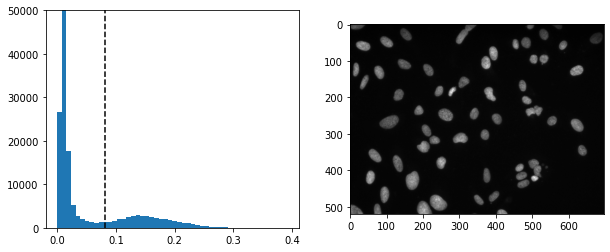

In [70]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels, bins=50)
plt.vlines(thresh_val, 0, 100000, linestyles='--')
plt.ylim([0,50000])

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)

plt.show()

In [73]:
from scipy import ndimage
# 이진화된 마스크에서 영역 찾아주는
labels, nlabels = ndimage.label(mask)

# 라벨별로 뭔가 해주는것같은데
# 라벨링 되어있는 데이터들을 이진화 시켜서 각각 저장
# 그래서 한개 사진이 라벨링 되어있는 갯수만큼 (여기서는 76개) 더 생김 
label_arrays = []
for label_num in range(1, nlabels + 1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

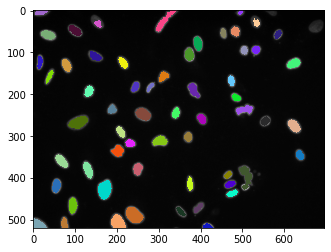

In [105]:
from matplotlib.colors import ListedColormap 
rand_cmap = ListedColormap(np.random.rand(256, 3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.show()